In [4]:
# # Quasi-Direct Methods (3D Descriptors + RBF SVM)
# - Uses extracted 3D descriptors (FPFH features)
# - Trains RBF-kernel SVM classifier
# - Evaluates with sklearn metrics + confusion matrix visualization

# %% Imports
import numpy as np
from pathlib import Path
import sys
sys.path.append('../Utils')
import configs 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [5]:
# %% Load 3D Features AFTER APPLING FPFH
TRAIN_SET = configs.TRAIN_FPFH_FEATURES_DIR 
TEST_SET = configs.TEST_FPFH_FEATURES_DIR 
X_train = np.load(TRAIN_SET / "features.npy")
y_train = np.load(TRAIN_SET / "labels.npy")

X_test  = np.load(TEST_SET / "features.npy")
y_test  = np.load(TEST_SET / "labels.npy")

print("Train features:", X_train.shape, "labels:", y_train.shape)
print("Test features:", X_test.shape, "labels:", y_test.shape)

Train features: (557, 33) labels: (557,)
Test features: (134, 33) labels: (134,)


Accuracy: 0.8283582089552238
F1 (macro): 0.7913119472252962  | F1 (weighted): 0.8324389917642915
Precision (macro): 0.7925013683634373  | Precision (weighted): 0.8428146623205811
Recall (macro): 0.808990145294111  | Recall (weighted): 0.8283582089552238

Classification Report:
               precision    recall  f1-score   support

         Ash      0.556     0.714     0.625         7
       Beech      0.931     0.844     0.885        32
 Douglas Fir      0.833     0.833     0.833        36
         Oak      1.000     0.750     0.857         4
        Pine      0.500     0.800     0.615         5
     Red Oak      0.900     0.947     0.923        19
      Spruce      0.828     0.774     0.800        31

    accuracy                          0.828       134
   macro avg      0.793     0.809     0.791       134
weighted avg      0.843     0.828     0.832       134



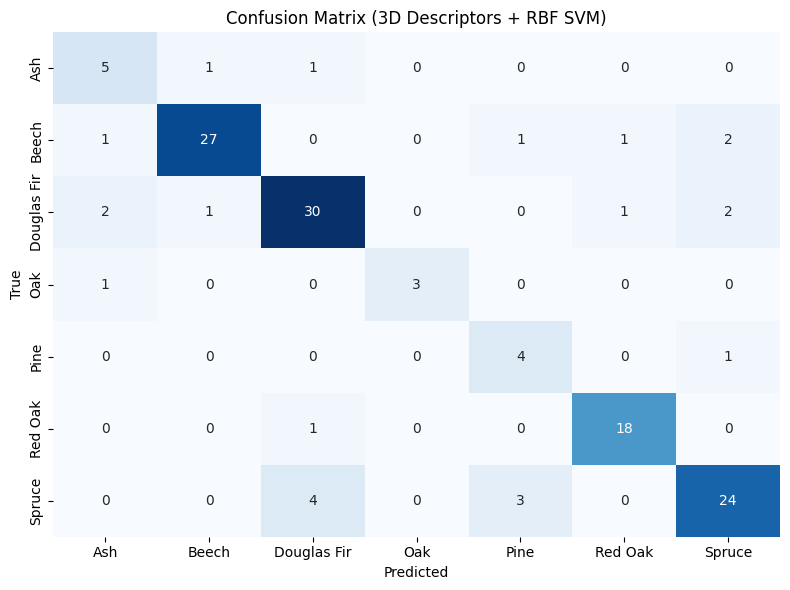

In [6]:

# %% Define RBF SVM Pipeline
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=10, gamma="scale", probability=True, class_weight="balanced"))
])

# %% Train
svm_clf.fit(X_train, y_train)

# %% Predict & Evaluate
y_pred = svm_clf.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
f1_m = f1_score(y_test, y_pred, average="macro")
f1_w = f1_score(y_test, y_pred, average="weighted")
prec_m = precision_score(y_test, y_pred, average="macro")
prec_w = precision_score(y_test, y_pred, average="weighted")
rec_m = recall_score(y_test, y_pred, average="macro")
rec_w = recall_score(y_test, y_pred, average="weighted")

print("Accuracy:", acc)
print("F1 (macro):", f1_m, " | F1 (weighted):", f1_w)
print("Precision (macro):", prec_m, " | Precision (weighted):", prec_w)
print("Recall (macro):", rec_m, " | Recall (weighted):", rec_w)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

# %% Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (3D Descriptors + RBF SVM)")
plt.tight_layout()
plt.show()


In [7]:
from sklearn.ensemble import BaggingClassifier


bagging_model = BaggingClassifier(
	svm_clf,
	n_estimators=100,
	random_state=42
)
bagging_model.fit(X_train, y_train)
print("bagging accuracy:", bagging_model.score(X_test, y_test))
print("bagging f1 score:", f1_score(y_test, bagging_model.predict(X_test), average="weighted"))
print("bagging precision:", precision_score(y_test, bagging_model.predict(X_test), average="weighted"))
print("bagging recall:", recall_score(y_test, bagging_model.predict(X_test), average="weighted"))



bagging accuracy: 0.8731343283582089
bagging f1 score: 0.8715360924316149
bagging precision: 0.8748463564530289
bagging recall: 0.8731343283582089


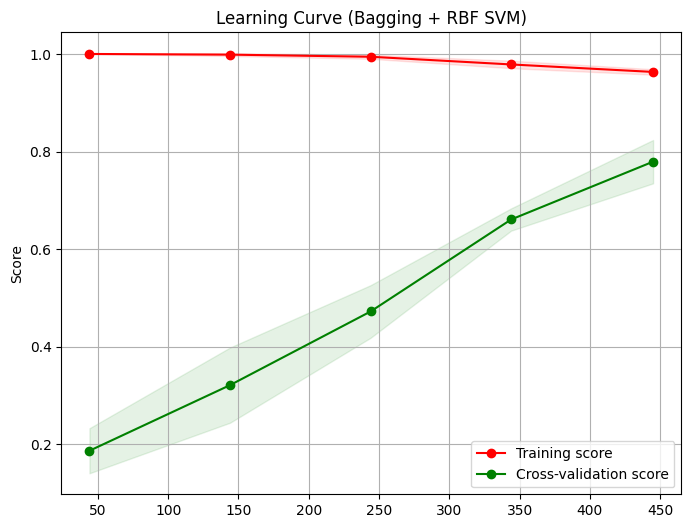

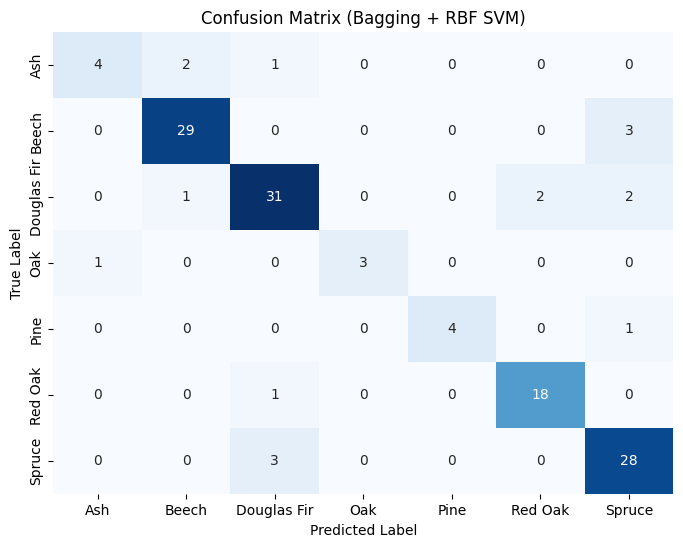

In [10]:

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
	bagging_model,
	X_train,
	y_train,
	cv=5,
	n_jobs=-1,
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

plt.figure(figsize=(8,6))
plt.title("Learning Curve (Bagging + RBF SVM)")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.legend(loc="best")
plt.ylabel("Score")
plt.grid()
plt.savefig("./plot/09_learning_curve_bagging_rbf_svm.png")
plt.show()

cm = confusion_matrix(y_test, bagging_model.predict(X_test))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
			xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix (Bagging + RBF SVM)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("./plot/09_confusion_matrix_bagging_rbf_svm.png")
plt.show()
